In [ ]:
## Data Initializing

In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

ModuleNotFoundError: No module named 'graph_tool'

In [2]:
import importlib
importlib.reload(dh)

<module 'data_handler' from 'D:\\Meruza\\GitHub\\TransportNet\\Stable Dynamic & Beckman\\data_handler.py'>

In [3]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 4]))
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

~	init_node	term_node	capacity	length	free_flow_time	b	power	speed	toll	link_type	;


NameError: name 'md' is not defined

### For Stable Dynamic the cell below:

In [4]:
handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 4]))
graph_data['graph_table']['Capacity'] = 2.5 * graph_data['graph_table']['Capacity']

model = md.Model(graph_data, graph_correspondences, 
                 total_od_flow, mu = 0, rho = 0.15)

graph_data['graph_table'].head()

,Init node,Term node,Capacity,Free Flow Time
0,1,117,22500.0,1.090459
1,2,87,22500.0,1.090459
2,3,74,22500.0,1.090459
3,4,233,22500.0,1.090459
4,5,165,22500.0,1.090459


## Experiment relative error vs gamma

### flow_star calculation for 2.5x capacity:

In [3]:
flows = []
times = []
iter_nums = []
primal_vals = []
dual_vals = []
dual_gaps = []

In [9]:
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustf', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'ustf' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_2.5xCapacity.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 3303 sec
Time ratio = 1.8929040131837573
Flow excess = 0.0065381140687974515

eps_abs = 31.622776601683793
Elapsed time: 3283 sec
Time ratio = 1.7974242927747626
Flow excess = 0.0026937149523986736

eps_abs = 100.0
Elapsed time: 3285 sec
Time ratio = 1.8499575639395323
Flow excess = 0.0011616504563118912

eps_abs = 316.22776601683796
Elapsed time: 3292 sec
Time ratio = 1.8508979190116792
Flow excess = 0.0002183223720781946

eps_abs = 1000.0
Elapsed time: 3290 sec
Time ratio = 1.8509012958031554
Flow excess = 6.285231726588236e-05



In [12]:
with open('anaheim_result_ustf_eps_abs_1_max_iter_10000_3xCapacity.pickle', 'wb') as f:
    pickle.dump(result, f)

In [10]:
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'ugd' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_2.5xCapacity.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 2809 sec
Time ratio = 1.6824643373488442
Flow excess = 0.019437826330495733

eps_abs = 31.622776601683793
Elapsed time: 2803 sec
Time ratio = 1.850633096695186
Flow excess = 0.009022138773227217

eps_abs = 100.0
Elapsed time: 2835 sec
Time ratio = 1.8507696151732687
Flow excess = 0.002693016123122227

eps_abs = 316.22776601683796
Elapsed time: 2904 sec
Time ratio = 1.8490051269530985
Flow excess = 0.001136132806513146

eps_abs = 1000.0
Elapsed time: 2821 sec
Time ratio = 1.846173095703354
Flow excess = 0.0003165824612991752



In [69]:
model.mu = 0
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'sd' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_2.5xCapacity.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 2860 sec
Time ratio = 1.6817912686360952
Flow excess = 0.022141660871784596

eps_abs = 31.622776601683793
Elapsed time: 2914 sec
Time ratio = 1.8506276564255122
Flow excess = 0.008236101571247323

eps_abs = 100.0
Elapsed time: 2993 sec
Time ratio = 1.8508507197659547
Flow excess = 0.0032011040126380674

eps_abs = 316.22776601683796
Elapsed time: 2881 sec
Time ratio = 1.849675447809613
Flow excess = 0.0009314130825985867

eps_abs = 1000.0
Elapsed time: 2893 sec
Time ratio = 1.842598989878519
Flow excess = 0.0003777599694165801



###  flow star calculated and saved above

In [ ]:
model.mu = 0.25
solver_kwargs = {'eps': 1e-2,
                 'eps_abs': 10,
                 'max_iter': 500}

tic = time.time()
result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs, verbose = True)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
flows.append(result['flows'])
times.append(result['times'])
iter_nums.append(result['iter_num'])
primal_vals.append(result['primal_func_history'])
dual_vals.append(result['dual_func_history'])

In [7]:
print(np.max(times[-1] / graph_data['graph_table']['Free Flow Time']))
print(np.max(flows[-1] / graph_data['graph_table']['Capacity']) - 1)

2.8045636761264485
0.023055659918054694


In [8]:
with open('anaheim_result_ustf_eps_abs_10_max_iter_10000_2xCapacity.pickle', 'wb') as f:
    pickle.dump(result, f)

### Results in another Notebook

In [22]:
model.mu = 0

solver_kwargs = {'eps': 1e-2,
                 'eps_abs': 5,
                 'max_iter': 1000}

tic = time.time()
result = model.find_equilibrium(solver_name = 'ustf', solver_kwargs = solver_kwargs, verbose = True)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
flows.append(result['flows'])
times.append(result['times'])
iter_nums.append(result['iter_num'])
primal_vals.append(result['primal_func_history'])
dual_vals.append(result['dual_func_history'])

Oracles created...
Universal similar triangles function...
Primal_init = 1.17521e+06
Dual_init = -1.17025e+06
Duality_gap_init = 4964.56

Iterations number: 1
Inner iterations number: 1
Primal_func_value = 1.17521e+06
Dual_func_value = -1.17025e+06
Duality_gap = 4964.56
Duality_gap / Duality_gap_init = 1

Iterations number: 100
Inner iterations number: 2
Primal_func_value = 1.1737e+06
Dual_func_value = -1.1736e+06
Duality_gap = 105.992
Duality_gap / Duality_gap_init = 0.0213497

Iterations number: 200
Inner iterations number: 1
Primal_func_value = 1.1737e+06
Dual_func_value = -1.17363e+06
Duality_gap = 69.6016
Duality_gap / Duality_gap_init = 0.0140197

Iterations number: 300
Inner iterations number: 1
Primal_func_value = 1.17369e+06
Dual_func_value = -1.17364e+06
Duality_gap = 51.3706
Duality_gap / Duality_gap_init = 0.0103475

Iterations number: 400
Inner iterations number: 2
Primal_func_value = 1.17368e+06
Dual_func_value = -1.17364e+06
Duality_gap = 34.2027
Duality_gap / Duality_ga

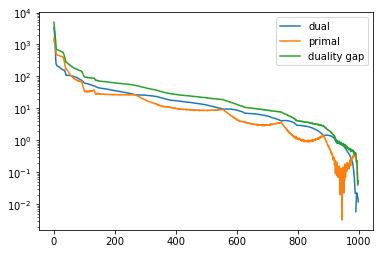

In [25]:
plt.plot(np.arange(len(dual_vals[-1])), dual_vals[-1] - np.min(dual_vals[-1]), label='dual')
plt.plot(np.arange(len(primal_vals[-1])), primal_vals[-1] - np.min(primal_vals[-1]), label='primal')
plt.plot(np.arange(len(result['duality_gap_history'])), 
         result['duality_gap_history'] - np.min(result['duality_gap_history']), 
         label='duality gap')

plt.legend()
plt.yscale('log')
plt.show()

### end for stable dynamic

### For Beckman's model:

In [3]:
model.mu = 0.25
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustf', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'ustf' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_Beckman.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 3405 sec
Time ratio = 2.9084886191164783
Flow excess = 0.8891944444444437

eps_abs = 31.622776601683793
Elapsed time: 3523 sec
Time ratio = 2.9107237309389733
Flow excess = 0.8891944444444417

eps_abs = 100.0
Elapsed time: 3570 sec
Time ratio = 2.9107237337628917
Flow excess = 0.8891944444444415

eps_abs = 316.22776601683796
Elapsed time: 3552 sec
Time ratio = 2.9107237337629024
Flow excess = 0.8891944444444448

eps_abs = 1000.0


/home/mk/Meruza/TransportNet/TransportNet-Nash-Wardrop_equilibrium_2019/universal_similar_triangles_function.py:65: RuntimeWarning: invalid value encountered in true_divide
  y = (alpha * u_prev + A_prev * t_prev) / A


ValueError: cannot compute fingerprint of empty list

In [15]:
model.mu = 0.25
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)[0:2]):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'ugd' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_Beckman.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 2800 sec
Time ratio = 2.3778826569074134
Flow excess = 1.3612209136725588

eps_abs = 31.622776601683793
Elapsed time: 2862 sec
Time ratio = 2.749070947261124
Flow excess = 1.0197947690406273



In [16]:
model.mu = 0.25
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)[0:2]):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'sd' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_Beckman.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 2860 sec
Time ratio = 2.411419003273585
Flow excess = 1.3261522004029418

eps_abs = 31.622776601683793
Elapsed time: 2867 sec
Time ratio = 2.724717673549527
Flow excess = 1.0346513807512774



In [7]:
model.mu = 0.25
max_iter = 10000

print('Frank-Wolfe without stopping criteria')
solver_kwargs = {'max_iter': max_iter}
tic = time.time()
result = model.find_equilibrium(solver_name = 'fwa', solver_kwargs = solver_kwargs, verbose = False)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))

print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')

with open('anaheim_result_' + 'fwa' + '_max_iter_' + str(max_iter) + 
          '_Beckman.pickle', 'wb') as f:
    pickle.dump(result, f)

Frank-Wolfe without stopping criteria
L_init =  1.0
Elapsed time: 1185 sec
Time ratio = 2.9107237337629295
Flow excess = 0.8891944444444517



### experiments for Beckman model ends here.

### experiments for Beckman model ends here.

#### flows_ star

In [9]:
with open('anaheim_result_fwa_3e-5.pickle', 'rb') as f:
    result_star = pickle.load(f)
    flow_star = result_star['flows']
    primal = result_star['primal_func_history']

In [9]:
primal

[1264518.0671581021,
 1222181.0009921354,
 1218451.4155435765,
 1212523.4279154581,
 1211034.901107549,
 1209121.9098656217,
 1208313.1420744851,
 1207757.8685086381,
 1207297.5174920973,
 1206918.6446882756,
 1206847.2436235324,
 1206662.476528934,
 1206431.7150182617,
 1206323.032232082,
 1206226.647595041,
 1206186.8848818541,
 1206103.1204818855,
 1206063.7078061434,
 1206032.3079034777,
 1205991.9777502944,
 1205939.6746319132,
 1205914.5045358799,
 1205888.1942881709,
 1205851.2875879216,
 1205836.1984073576,
 1205827.3614231409,
 1205796.5112790598,
 1205777.0014084242,
 1205778.6549308151,
 1205778.4582665353,
 1205756.269613351,
 1205745.5340009648,
 1205731.6602954632,
 1205726.1722821968,
 1205715.2955188472,
 1205712.4061292293,
 1205713.6129185027,
 1205714.604102795,
 1205698.0652911703,
 1205690.0660038169,
 1205681.4841722897,
 1205680.4975781851,
 1205673.4350094434,
 1205673.8615528282,
 1205668.123427246,
 1205662.0714706376,
 1205661.4303098335,
 1205661.3315272464,

In [11]:
with open('anaheim_result_ustf_1e-3.pickle', 'rb') as f:
    result = pickle.load(f)
    flow = result['flows']

In [12]:
delta = np.linalg.norm(flow - flow_star, ord = 1) / np.linalg.norm(flow_star, ord = 1)
delta

0.3868623683178405

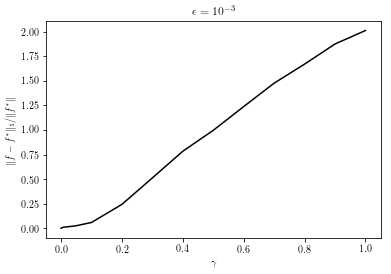

In [34]:
epsilon = 1e-3
plt.rc('text', usetex = True)
#plt.font = {'family': 'Verdana', 'weight': 'normal'}
#plt.rc('font', **font)
plt.plot(gammas, delta, 'black')
plt.title(r'$\epsilon = 10^{-3}$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\|f - f^*\|_1 / \|f^* \|$')
#plt.savefig('anaheim_delta_vs_gamma_{0:.0e}_withouty.png'.format(epsilon), dpi=300)
plt.show()

## Experiment 2  comparing USTF and UGD

In [5]:
epsilons = np.logspace(-1, -2, 10)[::-1]
epsilons

array([ 0.01      ,  0.0129155 ,  0.01668101,  0.02154435,  0.02782559,
        0.03593814,  0.04641589,  0.05994843,  0.07742637,  0.1       ])

In [6]:
iter_nums_for_epsilons = []
exec_times_for_epsilons = []
flows = []
duality_gap_histories = []

for epsilon in epsilons:
    tic = time.time()
    print('epsilon = ' + str(epsilon))
    result = model.model_solve(graph, graph_correspondences, total_od_flow,
                               solver_name = 'ustf',
                               mu = 0.25, rho = 0.15, epsilon = epsilon,
                               max_iter = 5000, verbose = True)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    exec_times_for_epsilons.append(toc - tic)
    iter_nums_for_epsilons.append(result['iter_num'])
    flows.append(result['flows'])
    duality_gap_histories.append(result['duality_gap_history'])

epsilon = 0.01
Oracles created...
Universal similar triangles function...
primal_init = 1264518.06716
dual_init = -1170970.03287
duality_gap_init = 93548.0342887
Iterations number: 1
Dual_gap_value = 93548.0342887
primal_func_value = 1264518.06716
Duality_gap / Duality_gap_init = 1.0
Iterations number: 5
Dual_gap_value = 68662.7943418
primal_func_value = 1253316.63483
Duality_gap / Duality_gap_init = 0.733984362834
iteration_num = 8: L_value = 31038.071462318658
iteration_num = 9: L_value = 31038.071462318658
iteration_num = 9: L_value = 62076.142924637315
iteration_num = 9: L_value = 124152.28584927463
Iterations number: 10
Dual_gap_value = 9696.98055771
primal_func_value = 1208953.96847
Duality_gap / Duality_gap_init = 0.10365776931
iteration_num = 12: L_value = 31038.071462318658
iteration_num = 12: L_value = 62076.142924637315
iteration_num = 13: L_value = 62076.142924637315
iteration_num = 13: L_value = 124152.28584927463
iteration_num = 15: L_value = 62076.142924637315
iteration_

iteration_num = 11: L_value = 15519.035731159329
iteration_num = 12: L_value = 15519.035731159329
Success!  Iterations number: 13
primal_func_value = 1206165.46445
Duality_gap / Duality_gap_init = 0.0231044749273
Phi big oracle elapsed time: 340 sec
Elapsed time: 341 sec
epsilon = 0.0464158883361
Oracles created...
Universal similar triangles function...
primal_init = 1264518.06716
dual_init = -1170970.03287
duality_gap_init = 93548.0342887
Iterations number: 1
Dual_gap_value = 93548.0342887
primal_func_value = 1264518.06716
Duality_gap / Duality_gap_init = 1.0
Iterations number: 5
Dual_gap_value = 68662.7943418
primal_func_value = 1253316.63483
Duality_gap / Duality_gap_init = 0.733984362834
iteration_num = 9: L_value = 15519.035731159329
iteration_num = 10: L_value = 15519.035731159329
Iterations number: 10
Dual_gap_value = 6733.996832
primal_func_value = 1208594.66968
Duality_gap / Duality_gap_init = 0.0719843755479
iteration_num = 11: L_value = 15519.035731159329
Success!  Iteratio

In [7]:
result = {}
result['epsilons'] = epsilons
result['iter_nums'] = iter_nums_for_epsilons
result['exec_times'] = exec_times_for_epsilons
#flows vectorS
result['flows'] = flows

In [8]:
with open('anaheim_result_ustf_correct_epsilons_iter_nums_exec_times.pickle', 'wb') as f:
    pickle.dump(result, f)

In [9]:
with open('anaheim_result_ugd_epsilons_iter_nums_exec_times.pickle', 'rb') as f:
    result_ugd = pickle.load(f)

In [10]:
epsilons_ugd = result_ugd['epsilons']
assert(np.all(epsilons == epsilons_ugd))
iter_nums_for_epsilons_ugd = result_ugd['iter_nums']
exec_times_for_epsilons_ugd = result_ugd['exec_times']
flows_ugd = result_ugd['flows']

In [13]:
delta = []
for flow in flows:
    delta.append(np.linalg.norm(flow - flow_star, ord = 1) / np.linalg.norm(flow_star, ord = 1))

In [14]:
delta_ugd = []
for flow in flows_ugd:
    delta_ugd.append(np.linalg.norm(flow - flow_star, ord = 1) / np.linalg.norm(flow_star, ord = 1))

In [11]:
epsilons

array([ 0.01      ,  0.0129155 ,  0.01668101,  0.02154435,  0.02782559,
        0.03593814,  0.04641589,  0.05994843,  0.07742637,  0.1       ])

In [ ]:
duality_gap_histories[0]

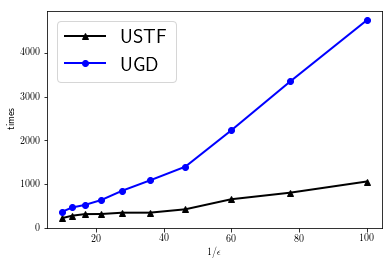

In [25]:
plt.rc('text', usetex = True)

plt.plot(1.0 / epsilons, exec_times_for_epsilons, 'black', label = 'USTF', linewidth=2, marker='^')
plt.plot(1.0 / epsilons, exec_times_for_epsilons_ugd, 'blue', label = 'UGD', linewidth=2, marker='o')
#plt.title(r'$USTF vs UGD$')

plt.xlabel(r'$1 / \epsilon$')
plt.ylabel(r'times')
plt.legend()
legend = plt.legend(loc=0,fontsize=20)
text = legend.get_texts()[1]
props = text.get_font_properties().copy()
text.set_fontproperties(props)
text.set_size(20)

#plt.savefig('anaheim_times_vs_eps_ustf_correct_ugd.png', dpi = 300)
plt.show()

In [ ]:
rho = 0.15
mu = 0.25
def primal_func_value(flows):
        sigma_sum_function = np.sum(graph.freeflow_times * flows * (rho * mu / (1.0 + mu) * 
                                    np.power(flows / graph.capacities, 1.0 / mu) + 1.0))
        return sigma_sum_function

## Experiment 3  comparing USTF and Frank-Wolfe

Берем абсолютные значения $\epsilon$ !

In [20]:
epsilons = 500.0 * np.array([1, 2, 3, 4, 5])[::-1]
epsilons = [100.0]
epsilons

[100.0]

In [21]:
iter_nums_for_epsilons = []
exec_times_for_epsilons = []
flows = []
primal_func_hist = []

for epsilon in epsilons:
    tic = time.time()
    print('epsilon = ' + str(epsilon))
    result = model.model_solve(graph, graph_correspondences, total_od_flow,
                               solver_name = 'ustf',
                               mu = 0.25, rho = 0.15, epsilon = epsilon,
                               max_iter = 5000, verbose = True)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    exec_times_for_epsilons.append(toc - tic)
    iter_nums_for_epsilons.append(result['iter_num'])
    flows.append(result['flows'])
    primal_func_hist.append(result['primal_func_history'])

epsilon = 100.0
Oracles created...
Universal similar triangles function...
primal_init = 1264518.06716
dual_init = -1170970.03287
duality_gap_init = 93548.0342887
Iterations number: 1
Dual_gap_value = 93548.0342887
primal_func_value = 1264518.06716
Duality_gap / Duality_gap_init = 1.0
Iterations number: 5
Dual_gap_value = 68662.7943418
primal_func_value = 1253316.63483
Duality_gap / Duality_gap_init = 0.733984362834
iteration_num = 8: L_value = 31038.071462318658
iteration_num = 9: L_value = 31038.071462318658
iteration_num = 9: L_value = 62076.142924637315
iteration_num = 9: L_value = 124152.28584927463
iteration_num = 9: L_value = 248304.57169854926
iteration_num = 9: L_value = 496609.1433970985
Iterations number: 10
Dual_gap_value = 11893.7242241
primal_func_value = 1210127.92151
Duality_gap / Duality_gap_init = 0.127140290168
iteration_num = 13: L_value = 62076.142924637315
iteration_num = 13: L_value = 124152.28584927463
iteration_num = 14: L_value = 124152.28584927463
iteration_n

iteration_num = 106: L_value = 7945746.294353576
iteration_num = 107: L_value = 7945746.294353576
iteration_num = 107: L_value = 15891492.588707153
iteration_num = 110: L_value = 3972873.147176788
iteration_num = 110: L_value = 7945746.294353576
Iterations number: 110
Dual_gap_value = 1139.99883553
primal_func_value = 1205809.47378
Duality_gap / Duality_gap_init = 0.0121862404079
iteration_num = 111: L_value = 7945746.294353576
iteration_num = 113: L_value = 3972873.147176788
iteration_num = 113: L_value = 7945746.294353576
Iterations number: 115
Dual_gap_value = 1095.35583771
primal_func_value = 1205810.6077
Duality_gap / Duality_gap_init = 0.0117090203556
iteration_num = 116: L_value = 1986436.573588394
iteration_num = 117: L_value = 1986436.573588394
iteration_num = 117: L_value = 3972873.147176788
iteration_num = 117: L_value = 7945746.294353576
iteration_num = 117: L_value = 15891492.588707153
iteration_num = 120: L_value = 3972873.147176788
Iterations number: 120
Dual_gap_value =

iteration_num = 216: L_value = 993218.286794197
iteration_num = 216: L_value = 1986436.573588394
iteration_num = 217: L_value = 1986436.573588394
iteration_num = 218: L_value = 1986436.573588394
iteration_num = 218: L_value = 3972873.147176788
iteration_num = 220: L_value = 1986436.573588394
iteration_num = 220: L_value = 3972873.147176788
Iterations number: 220
Dual_gap_value = 292.821283368
primal_func_value = 1205658.67028
Duality_gap / Duality_gap_init = 0.00313017035147
iteration_num = 222: L_value = 1986436.573588394
iteration_num = 223: L_value = 1986436.573588394
iteration_num = 223: L_value = 3972873.147176788
iteration_num = 223: L_value = 7945746.294353576
iteration_num = 224: L_value = 7945746.294353576
Iterations number: 225
Dual_gap_value = 282.212810557
primal_func_value = 1205657.22057
Duality_gap / Duality_gap_init = 0.00301676900752
iteration_num = 227: L_value = 1986436.573588394
iteration_num = 227: L_value = 3972873.147176788
iteration_num = 229: L_value = 1986436.

iteration_num = 324: L_value = 1986436.573588394
iteration_num = 325: L_value = 1986436.573588394
Iterations number: 325
Dual_gap_value = 102.798271256
primal_func_value = 1205617.36162
Duality_gap / Duality_gap_init = 0.00109888221636
iteration_num = 327: L_value = 993218.286794197
iteration_num = 327: L_value = 1986436.573588394
iteration_num = 328: L_value = 1986436.573588394
Success!  Iterations number: 328
primal_func_value = 1205616.14694
Duality_gap / Duality_gap_init = 0.0010645990671
Phi big oracle elapsed time: 12983 sec
Elapsed time: 13034 sec


In [22]:
with open('anaheim_result_ustf_correct_epsilon_absolute_100.pickle', 'wb') as f:
    result['exec_time'] = exec_times_for_epsilons
    pickle.dump(result, f)

In [35]:
delta = []
for flow in flows:
    delta.append(np.linalg.norm(flow - flow_star, ord = 1) / np.linalg.norm(flow_star, ord = 1))
delta

[0.0023969949321912044]

In [32]:
with open('anaheim_result_ustf_correct_epsilon_absolute_100.pickle', 'rb') as f:
    result_ustf = pickle.load(f)
    primal_vals_ustf = result_ustf['primal_func_history']
    flows = [result_ustf['flows']]
len(primal_vals_ustf) 

328

In [34]:
with open('anaheim_result_fwa_epsilon_absolute_100.pickle', 'rb') as f:
    result_fwa = pickle.load(f)
    primal_vals_fwa = result_fwa['primal_func_history']
    flows = [result_fwa['flows']]
len(primal_vals_fwa)

70

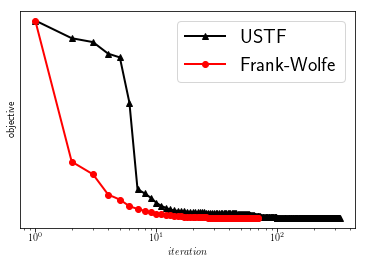

In [30]:
plt.rc('text', usetex = True)

plt.loglog(np.arange(1, len(primal_vals_ustf) + 1), primal_vals_ustf, 'black', label = 'USTF', linewidth=2, marker='^')
plt.loglog(np.arange(1, len(primal_vals_fwa) + 1), primal_vals_fwa, 'red', label = 'Frank-Wolfe', linewidth=2, marker='o')

plt.xlabel(r'$iteration$')
plt.ylabel(r'objective')
plt.legend()
legend = plt.legend(loc=0,fontsize=20)
text = legend.get_texts()[1]
props = text.get_font_properties().copy()
text.set_fontproperties(props)
text.set_size(20)

#plt.savefig('anaheim_primal__vs_iters_fwa_ustf_correct_eps_absolute_100_loglog.png', dpi = 300)
plt.show()

In [ ]:
eps_abs = 200.0
relative_error_fwa = 0.0046729734770496511
iters_fwa = 41


In [ ]:
eps_abs = 100.0
relative_error_fwa = 0.0023969949321912044
iters_fwa = 70
relative_error_ustf = 0.0021953059174468401
times_ustf = 328